In [1]:
import random as random
import re
from decimal import *
import locale
import itertools

import sympy
from sympy import *
import pandas
from pandas import DataFrame
import math 
import scipy.stats as stats
import numpy as np
from sympy import latex

import matplotlib
from matplotlib import pyplot as plt

from pyspark.sql import HiveContext 
from pyspark.sql import DecimalType 
from pyspark.sql import FloatType 
from pyspark import Row

import seaborn as sns
from IPython.core.display import HTML

#initialize some things for the IPython session
%pylab inline

init_printing()
locale.setlocale(locale.LC_ALL, 'en_US')
sns.set_style("darkgrid")
sns.set_context("talk")


#Generate a bar chart with data, title, y-label, x-label and whether
#the chart should be bar scale.
def bar_chart(label_to_count, title, y_label, x_label,log):
    OX = [x[0] for x in label_to_count]
    OY = [y[1] for y in label_to_count]
    fig = plt.figure()
    fig.suptitle(title, size=14)
    ax = plt.subplot(111)
    width = .35
    ind = np.arange(len(OY))
    rects = ax.bar(ind, OY, alpha=0.35, color='b', label=y_label)
    for ii,rect in enumerate(rects):
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2., 1.02*height, '%.2fM'% (OY[ii]),
                ha='center', va='bottom')
    ax.legend()
    ax.grid(True)
    ax.set_xticks(np.arange(len(OX)) + width)
    ax.set_xticklabels(OX)
    ax.set_ylabel(y_label)
    
    fig.autofmt_xdate()

#Take a 2D array of data and create a dataframe to display
#the data in tabular form
def print_table(column_labels, row_labels, contents):
    tmp = [[t[0]] + t[1] for t in zip(row_labels, contents)]
    df = DataFrame(tmp, columns=column_labels)
    pandas.set_option('display.max_colwidth', 100)
    display(HTML(df.to_html()))

#Truncate long lines on word boundaries
def truncate(line, length=40):
    if(len(line) > length):
        
        output_line = ""
        for token in line.split(' '):
            next = output_line + " " + token
            if len(next ) >= length:
                return next + "..."
            else:
                if len(output_line) == 0:
                    output_line = token
                else:
                    output_line = next
    else:
        return line

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#Data Investigation

One of the beneficial things that spark allows you to is to mix many different data analysis paradigms together and allow you to slice and dice your data using one of a couple different approaches:
* SQL on HDFS files directly via the SQLContext of SparkSQL
* SQL on data managed by Hive via the HiveContext of SparkSQL
* Spark's standard API primitives

We have ingested some payment data detailing the financial relationships between industry and physicians that is provided as part of the US government.

The structure of the data to be analyzed is as follows:
* reason
* physician_specialty
* amount
* physician_id
* payer

Considering this data is has been ingested into our Hadoop cluster and ETL'd into a Hive table, we'll start with some basic structural analysis via SQL to get a feel for the data.


In [2]:
sqlContext = HiveContext(sc)
num_rows = sqlContext.hql("select count(*) as cnt from open_payments.general").take(1)[0].cnt
print '# of Rows: ' + locale.format("%d", num_rows, grouping=True)

# of Rows: 2,607,085


##Number of Payments per Reason

In [3]:
count_by_reasons = sqlContext.hql("""select reason, count(*) as num_payments 
                                     from open_payments.general 
                                     group by reason 
                                     order by num_payments desc""").collect()

print_table(['Payment Reason', '# of Payments']\
           , [x[0] for x in count_by_reasons]\
           , [ [locale.format("%d", x[1], grouping=True)] for x in count_by_reasons]\
           )

,Payment Reason,# of Payments
0,Food_and_Beverage,"2,190,374"
1,Travel_and_Lodging,"135,034"
2,Education,"115,581"
3,Compensation_for_services_other_than_consulting_including_serving_as_faculty_or_as_a_speaker_at_...,"74,735"
4,Consulting_Fee,"45,071"
5,Gift,"23,111"
6,Honoraria,"10,858"
7,Compensation_for_serving_as_faculty_or_as_a_speaker_for_a_non-accredited_and_noncertified_contin...,"4,370"
8,Royalty_or_License,"2,981"
9,Current_or_prospective_ownership_or_investment_interest,"1,555"


##Which specialties are getting the most reimbursements?

In [5]:
totals_by_specialty = sqlContext.hql("""select physician_specialty, count(*) as cnt, sum(amount) as total
                                        from open_payments.general
                                        group by physician_specialty""").collect()
total_count_by_specialty = sum([t[1] for t in totals_by_specialty])
top_count_by_specialty = sorted(totals_by_specialty, key=lambda t : t[1], reverse=True)[0:10]
print_table(['Specialty', '# of Payments', "% of Payments"]\
           , [x[0] for x in top_count_by_specialty]\
           , [ [ locale.format("%d", x[1], grouping=True)\
               , '{0:.2f}%'.format(100*x[1]/total_count_by_specialty)\
               ] \
               for x in top_count_by_specialty]\
           )

,Specialty,# of Payments,% of Payments
0,Allopathic & Osteopathic Physicians/ Family Medicine,"430,550",16.00%
1,Allopathic & Osteopathic Physicians/ Internal Medicine,"416,978",15.00%
2,Allopathic & Osteopathic Physicians/ Internal Medicine/ Cardiovascular Disease,"160,299",6.00%
3,Allopathic & Osteopathic Physicians/ Psychiatry & Neurology/ Psychiatry,"120,923",4.00%
4,Allopathic & Osteopathic Physicians/ Internal Medicine/ Gastroenterology,"92,441",3.00%
5,Allopathic & Osteopathic Physicians/ Psychiatry & Neurology/ Neurology,"89,573",3.00%
6,Other Service Providers/ Specialist,"80,564",3.00%
7,Allopathic & Osteopathic Physicians/ Obstetrics & Gynecology,"65,392",2.00%
8,"Allopathic & Osteopathic Physicians/ Internal Medicine/ Endocrinology, Diabetes & Metabolism","62,856",2.00%
9,Allopathic & Osteopathic Physicians/ Urology,"61,149",2.00%


##Which specialties are getting the most reimbursement amounts?

In [6]:
#Which specialties are getting the most money?
top_total_by_specialty = sorted(totals_by_specialty, key=lambda t : t[2], reverse=True)[0:10]
total_amount_by_specialty = sum([t[2] for t in totals_by_specialty])
print_table(['Specialty', 'Amount of Payments', '% of Total Amount']\
           , [x[0] for x in top_total_by_specialty]\
           , [ ['$' + locale.format('%0.2f', x[2], grouping=True)\
               , '{0:.2f}%'.format(100*x[2]/total_amount_by_specialty)\
               ] \
               for x in top_total_by_specialty\
             ]\
           )

,Specialty,Amount of Payments,% of Total Amount
0,Allopathic & Osteopathic Physicians/ Orthopaedic Surgery,"$80,156,766.29",17.42%
1,Allopathic & Osteopathic Physicians/ Internal Medicine,"$26,608,638.24",5.78%
2,Allopathic & Osteopathic Physicians/ Internal Medicine/ Cardiovascular Disease,"$24,290,215.67",5.28%
3,Allopathic & Osteopathic Physicians/ Psychiatry & Neurology/ Psychiatry,"$18,714,797.66",4.07%
4,Other Service Providers/ Specialist,"$17,475,128.61",3.80%
5,Allopathic & Osteopathic Physicians/ Psychiatry & Neurology/ Neurology,"$16,972,217.17",3.69%
6,Allopathic & Osteopathic Physicians/ Neurological Surgery,"$15,848,292.54",3.44%
7,"Allopathic & Osteopathic Physicians/ Internal Medicine/ Endocrinology, Diabetes & Metabolism","$15,518,843.36",3.37%
8,Allopathic & Osteopathic Physicians/ Internal Medicine/ Gastroenterology,"$14,568,103.03",3.17%
9,Allopathic & Osteopathic Physicians/ Family Medicine,"$12,401,074.79",2.69%


# Outlier Analysis via Median Absolute Divergence

##Outlier Analysis

Outlier analysis or identification is a technique to identify observations that appears to deviate markedly from other observations in a dataset.  For our purposes, we're going to look for outliers within payments for a given reason (e.g. Gift) and to a given specialty (e.g. Dentists).


##Median Absolute Divergence

Often outlier techniques based on statistics involve some threshold based around a variance measure, like standard deviation.  Since our payment data is unlikely to be normally distributed, the [Engineering Statistics
Handbook](http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm) suggests another approach:

>The standard deviation is an example of an estimator that is the best we can do if the underlying distribution is normal. However, it lacks robustness of validity. That is, confidence intervals based on the standard deviation tend to lack precision if the underlying distribution is in fact not normal.

>The median absolute deviation and the interquartile range are estimates of scale that have robustness of validity. However, they are not particularly strong for robustness of efficiency.

>If histograms and probability plots indicate that your data are in fact reasonably approximated by a normal distribution, then it makes sense to use the standard deviation as the estimate of scale. However, if your data are not normal, and in particular if there are long tails, then using an alternative measure such as the median absolute deviation, average absolute deviation, or interquartile range makes sense.

Given this guidance, we will follow a suggestion by [Iglewicz and Hoaglin](http://www.itl.nist.gov/div898/handbook/eda/section4/eda43.htm#Iglewicz) and threshold the data by a z-score using the median absolute divergence as a variance measure.  First, let's define the median absolute deviation:

Given univariate data $X$ with $\tilde{x}=median(X)$
$$MAD(X) = median( {\forall x_i \in X \lvert |x_i - \tilde{x}| })$$


We'll define an outlier payment within a set of payments with the same physician specialty and reason as:
>For a set of univariate data $X$ with $\tilde{x} = $ median($X$), an outlier is an element $x_i \in X$
>such that $M_i = \frac{0.6745(x_i − \tilde{x} )}{MAD(X)} > 3.5$, where
>$M_i$ is denoted the *modified Z-score*.


In [8]:
#Some useful functions for more advanced analytics

#Joins in spark take RDD[K,V] x RDD[K,U] => RDD[K, [U,V] ]
#This function returns U
def join_lhs(t):
    return t[1][0]

#Joins in spark take RDD[K,V] x RDD[K,U] => RDD[K, [U,V] ]
#This function returns V
def join_rhs(t):
    return t[1][1]

#Add a key/value to a dictionary and return the dictionary
def annotate_dict(d, k, v):
    d[k] = v
    return d

#Plots a density plot of a set of points representing inliers and outliers
#A rugplot is used to indicate the points and the outliers are marked in red.
def plot_outliers(inliers, outliers, reason):
    fig, ax = plt.subplots(nrows=1)
    sns.distplot(inliers + outliers, ax=ax, rug=True, hist=False)
    ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)
    fig.suptitle('Distribution for {} Values'.format(reason), size=14)

#Using reservoir sampling, uniformly sample N points
#requires O(N) memory
def sample_points(points, N):
    sample = [];
    for i,point in enumerate(points):
        if i < N:
            sample.append(point)
        elif i >= N and random.random() < N/float(i+1):
            replace = random.randint(0,len(sample)-1)
            sample[replace] = point
    return sample


In [9]:
#Outlier analysis using Median Absolute Divergence

#Grab data using Spark-SQL and filter with spark core RDD operations to only yield the data
#we want, ones with physicians, payers and reasons
reason_amount_pairs = sqlContext.hql("""select reason, physician_specialty, amount, physician_id, payer 
                                        from open_payments.general
                                     """)\
                               .map(lambda row: ( "{}_{}".format(row.reason, row.physician_specialty)\
                                               , dict(amount=row.amount\
                                                     ,physician_id=row.physician_id\
                                                     ,payer=row.payer\
                                                     ,specialty=row.physician_specialty\
                                                     )\
                                               )\
                                     )

#Returns a function which will extract the median at location 'key'
#a list of dictionaries.
def median_func(key):
    #Right now it uses numpy's median, but probably a quickselect implementation is called for
    #as I expect this doesn't scale
    return lambda partition_value : (partition_value[0], np.median([d[key] for d in partition_value[1]]))

#Compute the modified z-score for use by  as per Iglewicz and Hoaglin:
#Boris Iglewicz and David Hoaglin (1993),
#"Volume 16: How to Detect and Handle Outliers",
#The ASQC Basic References in Quality Control: Statistical Techniques
#, Edward F. Mykytka, Ph.D., Editor.
def get_z_score(reason_to_diff):
    med = join_rhs(reason_to_diff)
    if med > 0:
        #note that 0.6745 is the z-score for the 75th percentile
        return 0.6745 * join_lhs(reason_to_diff)['diff'] / med
    else:
        return 0

def is_outlier(thresh):
    return lambda reason_to_diff : get_z_score(reason_to_diff) > thresh

#Return a RDD of a uniform random sample of a specified size per key
def get_inliers(reason_amount_pairs, size=2000):
    group_by_reason = reason_amount_pairs.groupByKey()
    return group_by_reason.map(lambda t : (t[0], sample_points(t[1], size)))


#Return the outliers based on Median Absolute Divergence
#See http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm for more info.
#The input key structure is reason_specialty => dict(amount, physician, payer, specialty)
def get_outliers(reason_amount_pairs, thresh=3.5):
    """
        This uses the median absolute divergence (MAD) statistic to find
        outliers for each reason x specialty partitions.
        
        Outliers are computed as follows: 
        * Let X be all the payments for a given specialty, reason pair
        * Let x_i be a payment in X
        * Let MAD be the median absolute divergence, defined as
          MAD = median( for all x in X, | x - median(X)| )
        * Let M_i be the modified z-score for payment x_i, defined as
          0.6745*(x_i − median(X) )/MAD
        
        As per the recommendations by Iglewicz and Hoaglin, a payment is
        considered an outlier if the modified z-score, M_i > thresh, which
        is 3.5 by default.
        
        
        REFERENCE:
        Boris Iglewicz and David Hoaglin (1993),
        "Volume 16: How to Detect and Handle Outliers",
        The ASQC Basic References in Quality Control: Statistical Techniques,
        Edward F. Mykytka, Ph.D., Editor.
    """
    
    group_by_reason = reason_amount_pairs.groupByKey()
   
    #Filter by only reason/specialty's with more than 1k entries
    #and compute the median of the amounts across the partition.
    
    #NOTE: There may be some scalability challenges around median, so some care should
    #be taken to reimplement this if partitioning by (reason, specialty)
    #does not yield small enough numbers to handle in an individual map function.
    reason_to_median = group_by_reason.filter(lambda t: len(t[1]) > 1000) \
                                      .map(median_func('amount'))
   
    #Join the base, non-grouped data, with the median per key, consider just the payments more than the median
    #since we're looking for large money outliers and annotate the dictionary for each entry x_i with the following:
    # * diff = |x_i - median(X)| in the parlance of the comment above.
    #   NOTE: Strictly speaking I can drop the absolute value since x_i > median(X), but I choose not to.
    # * median = median(X)
    # 
    reason_abs_dist_from_median = \
        reason_amount_pairs.join(reason_to_median) \
                           .filter(lambda t : join_lhs(t)['amount'] > join_rhs(t)) \
                           .map(lambda t: (t[0],dict( diff=abs(join_lhs(t)['amount'] - join_rhs(t))\
                                                    , row=annotate_dict(join_lhs(t) \
                                                                       , 'median' \
                                                                       , join_rhs(t) \
                                                                       )\
                                                    )\
                                          )\
                                )
                
    # Given diff cached per element, we need only compute the median of the diffs
    # to compute the MAD.  
    #Remember, MAD = median( for all x in X, | x - median(X)| )
    reason_to_MAD = reason_abs_dist_from_median.groupByKey() \
                                               .map(median_func('diff'))
  
    
    # Joining the grouped data to get both | x_i - median(X) | and MAD in the same place, we can compute
    # the modified z-score, 0.6475*| x_i - median(X)| / MAD, and filter by the ones which are more than threshold
    # we can then do some pivoting of keys and sort by that threshold to give us the ranked list of outliers.
    return reason_abs_dist_from_median.join(reason_to_MAD) \
                                      .filter(is_outlier(thresh))\
                                      .map(lambda t: (get_z_score(t), annotate_dict(join_lhs(t)['row'], 'key', t[0]))) \
                                      .sortByKey(False) \
                                      .map(lambda t: (t[1]['key'], annotate_dict(t[1], 'mad', t[0])))

#Filter the outliers by reason and return a RDD with just the outliers of a specified reason.
def get_by_reason(outliers, reason):
    return outliers.filter(lambda t: str.startswith(t[0].encode('ascii', 'ignore'),reason))


#Get the outliers based on a modified z-score threshold of 3.5
outliers = get_outliers(reason_amount_pairs, 3.5)
#Get a sample per specialty/reason partition
inliers = get_inliers(reason_amount_pairs)

In [10]:
#display the top k outliers in a table and a distribution plot
#of an inlier sample along with the outliers rug-plotted in red
def display_info(inliers_raw, outliers_raw_tmp, reason, k=None):
    outliers_raw = []
    if k is None:
        outliers_raw = sorted(outliers_raw_tmp, key=lambda d:d[1]['amount'], reverse=True)
    else:
        outliers_raw = sorted(outliers_raw_tmp, key=lambda d:d[1]['amount'], reverse=True)[0:k]
    inlier_pts = []
    for i in [d[1] for d in inliers_raw]:
        for j in i:
            inlier_pts.append(j['amount'])
    outlier_pts= [d[1]['amount'] for d in outliers_raw]
    plot_outliers(inlier_pts[0:1500], outlier_pts, reason)

    print_table(['Physician','Specialty', 'Payer', 'Amount']\
               , [d[1]['physician_id'] for d in outliers_raw]\
               , [ [ d[1]['specialty'] \
                   , d[1]['payer'].encode('ascii', 'ignore') \
                   , '$' + locale.format('%0.2f', d[1]['amount'], grouping=True)\
                   ] \
                 for d in outliers_raw]\
               )

,Physician,Specialty,Payer,Amount
0,225073,Dental Providers/ Dentist/ General Practice,"Dentalez Alabama, Inc.","$56,422.00"
1,380517,Dental Providers/ Dentist,DENTSPLY IH Inc.,"$8,672.50"
2,167931,Dental Providers/ Dentist,DENTSPLY IH Inc.,"$8,672.50"
3,380073,Dental Providers/ Dentist/ General Practice,Benco Dental Supply Co.,"$7,570.00"
4,403926,Dental Providers/ Dentist,"A-dec, Inc.","$5,430.00"
5,429612,Dental Providers/ Dentist,"PureLife, LLC","$5,058.72"
6,404935,Dental Providers/ Dentist,"A-dec, Inc.","$5,040.00"
7,8601,Dental Providers/ Dentist/ General Practice,"DentalEZ, Inc.","$3,876.35"
8,385314,Dental Providers/ Dentist/ General Practice,"Henry Schein, Inc.","$3,789.99"
9,389592,Dental Providers/ Dentist/ General Practice,"Henry Schein, Inc.","$3,789.99"


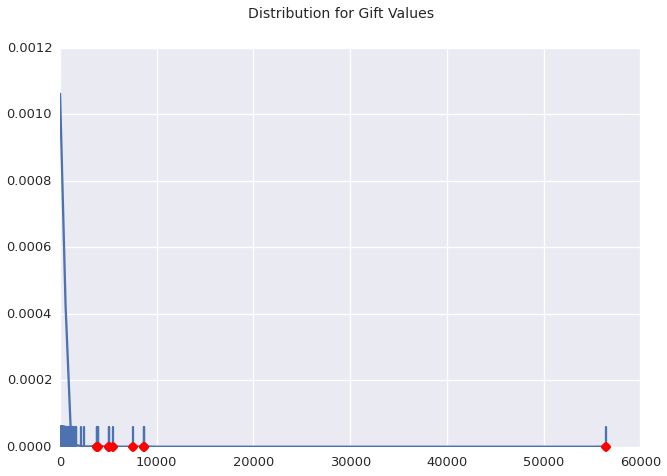

In [11]:
gift_outliers = get_by_reason(outliers, 'Gift').collect()
gift_inliers = get_by_reason(inliers, 'Gift').collect()
display_info(gift_inliers, gift_outliers, 'Gift', 10)

,Physician,Specialty,Payer,Amount
0,200720,Allopathic & Osteopathic Physicians/ Surgery,Teleflex Medical Incorporated,"$68,750.00"
1,28946,Dental Providers/ Dentist/ General Practice,"BIOLASE, INC.","$13,297.15"
2,28946,Dental Providers/ Dentist/ General Practice,"BIOLASE, INC.","$8,111.82"
3,28946,Dental Providers/ Dentist/ General Practice,"BIOLASE, INC.","$8,111.82"
4,418150,Dental Providers/ Dentist/ Orthodontics and Dentofacial Orthopedics,Ormco Corporation,"$6,633.89"
5,200720,Allopathic & Osteopathic Physicians/ Surgery,Teleflex Medical Incorporated,"$6,569.06"
6,266160,Allopathic & Osteopathic Physicians/ Psychiatry & Neurology/ Psychiatry,"Intuitive Surgical, Inc.","$6,000.00"
7,483388,Allopathic & Osteopathic Physicians/ Urology,"Auxilium Pharmaceuticals, Inc.","$5,000.00"
8,241043,Allopathic & Osteopathic Physicians/ Internal Medicine/ Cardiovascular Disease,Eisai Inc.,"$4,365.00"
9,328465,,"SonaCare Medical, LLC","$4,300.00"


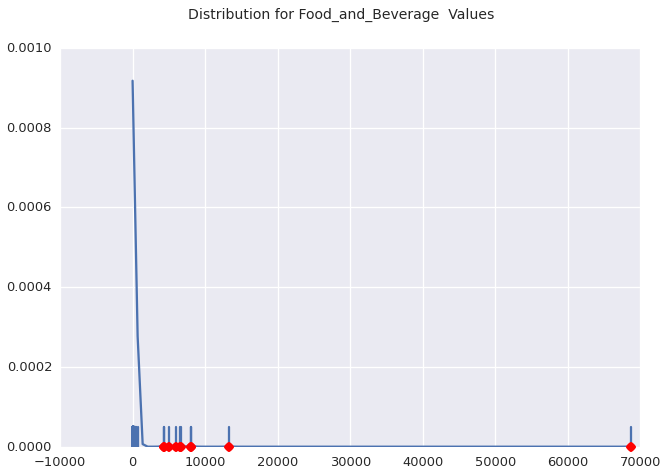

In [12]:
food_outliers = get_by_reason(outliers, 'Food_and_Beverage').collect()
food_inliers = get_by_reason(inliers, 'Food_and_Beverage').collect()
display_info(food_inliers, food_outliers, 'Food_and_Beverage ', 10)